# Homework 5 - An Analysis of Shakespeare using Clustering Techniques

There are three parts to this notebook:
* <a href="#the_walkthrough">A general discussion of our analysis</a>,
* <a href="#the_details">The details for each step</a>,
* <a href="#exploratory_points">Exploratory Points<a>


<a id='the_walkthrough'></a>

# The Walkthrough

## Data Preparation

Our first step was to download and parse the text files. We decided to utilse the XML files prepared by <a href='http://www.ibiblio.org/bosak/'>John Bosak</a>. As the XML files had a well defined structure, parsing it with an XML parser (we used xml.etree.ElementTree) was relatively simple. The file dataset.py is responsible for reading the files in and writing out a pickle, dataset.pickle, that stores all plays in pandas dataframe.

We next loaded the dataset and looked at the frequencies of the words in all the plays. Displaying the top 100 in a word cloud exposed some interesting issues with Shakespearean words.
<img src='./wordcloud.png'/>
It is interesting to see some 'Olde English' words in there - thee, thou, etc. The modern day Python libraries will obviously be using modern day English libraries and so we'll need to be careful to take into account the older style of English.

<a id='the_details'></a>

# The Details

This section provides the details of our analysis. Some of the steps are computationally expensive - these will be pointed out.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud # pip install wordcloud
# #nltk.download()

%matplotlib inline  

%run 'dataset.py'
%run 'processing.py'

Play  ['Hamlet' 'Othello' 'Henry V' 'Timon of Athens' 'Measure for Measure'
 'Antony and Cleopatra' 'King Lear' 'King Edward III' 'Julius Caesar'
 'Macbeth' 'Titus Andronicus' "The Winter's Tale" 'Richard III'
 'As You Like It' 'Coriolanus' 'The Tempest' 'Henry IV Part 2'
 'Romeo and Juliet' 'Pericles' 'Henry IV Part 1' 'Cymbeline'
 'The Two Noble Kinsmen' "Love's Labour's Lost" 'The Taming of the Shrew'
 'The Merchant of Venice' 'Troilus and Cressida' 'King John'
 "All's Well That Ends Well" 'Richard II' 'Henry VIII'
 'The Two Gentlemen of Verona' 'The Merry Wives of Windsor'
 'Henry VI Part 3' 'Much Ado About Nothing' 'Henry VI Part 1'
 'Henry VI Part 2' 'Twelfth Night' 'The Comedy of Errors'
 "A Midsummer Night's Dream"]
[('I', 20056), ('And', 7099), ('thou', 4499), ('The', 3454), ('thy', 3453), ('shall', 3153), ('thee', 3078), ('To', 2988), ('That', 2719), ('But', 2390)]


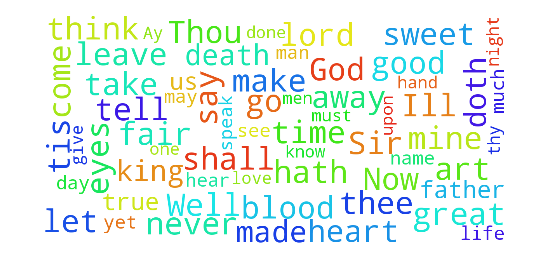

In [2]:
ds = DataSet()
ds.load()

tokens = Processing.get_tokens(ds.df['Utterance'], [Processing.remove_punctuation], [Processing.remove_stopwords])

allWordDist = nltk.FreqDist(tokens)

common_words = allWordDist.most_common(100)

# Print the top 20 words - shows some 'olde english' stop words
print(allWordDist.most_common(20))

words = ' '.join(entry[0] for entry in common_words)


# lower max_font_size
wordcloud = WordCloud(background_color='white', max_font_size=80,height=600, width=1200).generate(words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('wordcloud.png', dpi=200)
plt.show()

# POS Tagging

Part Of Speech (POS) tagging allows us to identify the structure of the sentence. This is particularly useful in removing proper nouns, such as people's names. For example, whenever we ranked the words earlier the word MacBeth scores quite highly in the play MacBeth. This doesn't give us a lot of information, so it may be useful to remove people's names. 

We use pos_tag from NLTK to remove the proper nouns ('NNP') from all the plays. Our results are disappionting: we do indeed remove macbeth, but would also remove countries such as Scotland, England, Ireland and other words that definately aren't proper nouns: show, began, which, speak, witch. Macbeth without witches would be a tragedy!

In [3]:
plays_utterances = ds.get_by_play()

In [4]:
# Strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
# Requires average_perceptron_tagger from NLTK download
from nltk.tag import pos_tag

for title, text in plays_utterances.items():
    tokens = nltk.word_tokenize(text)
    tagged = pos_tag(tokens) #use NLTK's part of speech tagger
    propernouns = [word for word,pos in tagged if pos == 'NNP' ]

    
    if( title == 'macbeth'):
        print('Play: Macbeth')
        print('Proper Nouns: ',propernouns)



Play: Macbeth
Proper Nouns:  ['Macbeth', 'Graymalkin', 'Paddock', 'Anon', 'Fair', 'Hover', 'Who', 'Hail', 'Say', 'Macdonwald', 'Do', 'Show', 'Macbeth', 'Disdaining', 'Which', 'Till', 'Which', 'Till', 'O', 'Discomfort', 'Mark', 'Scotland', 'Norweyan', 'Began', 'Dismay', 'Macbeth', 'Banquo', 'Or', 'Golgotha', 'Go', 'Ross', 'God', 'Whence', 'Fife', 'Norweyan', 'Norway', 'Cawdor', 'Till', 'Bellona', 'Point', 'Great', 'Sweno', 'Norways', 'Till', 'Saint', 'Colme', 'Cawdor', 'Macbeth', 'Macbeth', 'Sister', "'d", "'d", 'Aleppo', "Thou'rt", 'Hang', 'Shall', 'Wreck', 'Macbeth', 'Posters', 'Thus', 'Speak', 'Macbeth', 'Glamis', 'Macbeth', 'Cawdor', 'Macbeth', 'Are', 'ye', 'Which', 'Speak', 'Macbeth', 'Thou', 'Macbeth', 'Banquo', 'Banquo', 'Macbeth', 'Stay', 'Sinel', 'Glamis', 'Cawdor', 'Cawdor', 'A', 'Stands', 'No', 'Cawdor', 'Say', 'Speak', 'Cawdor', 'Macbeth', 'Thy', 'Which', 'Norweyan', 'Strange', 'As', 'Came', 'Thy', 'Cawdor', 'Cawdor', 'Who', 'Which', 'Norway', 'Glamis', 'Cawdor', 'Cawdor', '

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.snowball import SnowballStemmer




stemmer = SnowballStemmer("english")


def run_tfidf(words, stem=False, max_features=1000):
    all_stopwords = stopwords.words('english') 

    #adding Shakespeare-ean stop-words
    shaksp_stopwords = ('thee', 'thou', 'thy', 'thine')
    all_stopwords += shaksp_stopwords

    tfidf_vectorizer = TfidfVectorizer(#max_features=200000,
                                        max_features=max_features,
                                        min_df=0.2, 
                                        max_df=0.8, 
                                        stop_words=all_stopwords,
                                        use_idf=True, 
                                        tokenizer=tokenize_and_stem if stem else tokenize_only, 
                                        ngram_range=(1,3))

    tfidf_matrix = tfidf_vectorizer.fit_transform(words)
    
    return tfidf_matrix, tfidf_vectorizer.get_feature_names()


def strip_proppers_POS(tokens):
    tagged = pos_tag(tokens) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

    
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems



def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
            
    filtered_tokens = strip_proppers_POS(filtered_tokens)
    
    return filtered_tokens    
    


In [6]:
plays_utterances = ds.get_by_play()
tfidf_matrix_plays, terms_plays = run_tfidf(plays_utterances.values())

speakers_utterances = ds.get_by_speaker()
tfidf_matrix_speakers, terms_speakers = run_tfidf(speakers_utterances.values())

## KMeans

In [7]:
from sklearn.cluster import KMeans
from collections import Counter
import pickle


def run_single_kmeans(tfidf_matrix, max_iter=300, n_init=10, range_clusters = range(5,6), title=None):
    
    kms = []
    
    for num_clusters in range_clusters:
        print('KMeans cluster ', num_clusters)

        km = KMeans(n_clusters=num_clusters,
                    max_iter=max_iter,             # Default is 300
                    n_init=n_init,                 # Default is 10
                    precompute_distances=True, # Faster but takes more memory
                    random_state=47,
                    n_jobs=-1)

        km.fit(tfidf_matrix)

        kms.append( {'num_clusters': num_clusters, 
                    'cluster_centers':km.cluster_centers_, 
                    'clusters':km.labels_.tolist(), 
                    'inertia':km.inertia_})
    
    kms_df = pd.DataFrame(kms, index=range_clusters)

    if title is not None:
        kms_df.to_pickle('kms_{}_{}_{}.pickle'.format(title, max_iter, n_init))
        
    return kms_df


            
            
def run_kmeans(tfidf_matrix, max_clusters, title=None):
    
    max_iters = [1, 10, 100, 300, 1000, 10000]
    n_inits = [1, 5, 10, 50, 100]
    range_clusters = range(1, max_clusters)
    
    kms_df = None
    
    for max_iter in max_iters:
        print('Max iter: ', max_iter)
        for n_init in n_inits:
            print('n_init: ', n_init)
          
            run_single_kmeans(tfidf_matrix, max_iter, n_init, title=title)
    

            

# The following lines are deliberately commented out
# They will find the hyper-parameters for max_iters and n_init
#run_kmeans(tfidf_matrix_plays, len(plays_utterances))
#run_kmeans(tfidf_matrix_plays, len(speakers_utterances))

kms_df_plays = run_single_kmeans(tfidf_matrix_plays, title='plays')
kms_df_speakers = run_single_kmeans(tfidf_matrix_speakers, title='speakers')

KMeans cluster  5
KMeans cluster  5


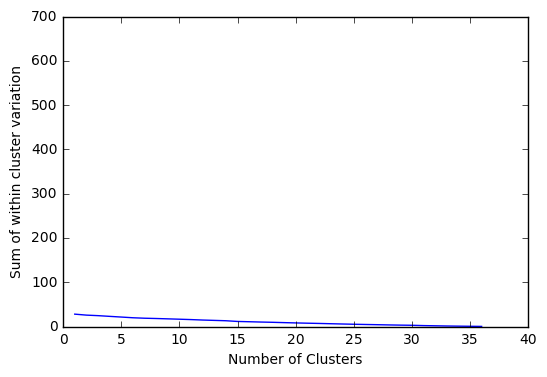

In [8]:
# For the plays, plot the variation as a fn of the number of clusters
# Compare the difference when running with
#  i) n_init=1, max_iters=1
# ii) n_init=100, max_iters=10000

kms_df1_1 = pd.read_pickle('km_byplay/kms_1_1.pickle')
#kms_df10000_100 = pd.read_pickle('km_byplay/kms_10000_100.pickle')
kms_df10000_100 = pd.read_pickle('kms_speakers_300_10.pickle')

fig, ax = plt.subplots()
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of within cluster variation')
plt.plot(kms_df1_1.num_clusters, kms_df1_1.inertia, label='n_init=1, max_iters=1')
plt.plot(kms_df10000_100.num_clusters, kms_df10000_100.inertia, label='n_init=100, max_iters=10000')
plt.savefig('km_inertia_both.png', dpi=200)
plt.show()


In [12]:
def make_frame(utterances, clusters):

    plays_dict = { 'title': list(utterances.keys()),'cluster': clusters}

    frame = pd.DataFrame(plays_dict, index = [clusters] , columns = [
            'title', 'cluster'])
    

frame_plays = make_frame(plays_utterances, kms_df_plays.iloc[0].clusters)
frame_speakers = make_frame(speakers_utterances, kms_df_speakers.iloc[0].clusters)



In [10]:

totalvocab_stemmed = []
totalvocab_tokenized = []
for i in plays_utterances.values():
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)


In [11]:
 def top_terms(frame, km, terms):
    print("Top terms per cluster:")
    print()
    order_centroids = km.cluster_centers.argsort()[:, ::-1]
    for i in range(km.num_clusters):

        print("Cluster {} words:".format(i))
        for ind in order_centroids[i, :10]:
            print(' {}'.format(terms[ind]))
        print()

        print("Cluster {} titles:".format(i))
        for title in frame['title'].values.tolist():
            print(' {},'.format(title))
        print()
        print()
    

top_terms(frame_plays, kms_df_plays.iloc[0], terms_plays)

Top terms per cluster:

Cluster 0 words:
 duke
 signior
 friar
 hector
 letter
 ring
 count
 cousin
 chain
 ducats

Cluster 0 titles:


TypeError: 'NoneType' object is not subscriptable

## MDS

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [ ]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: '0', 
                 1: '1', 
                 2: '2', 
                 3: '3', 
                 4: '4'}

In [ ]:
%matplotlib inline

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=frame['cluster'], title=frame['title'])) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that we use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i, row in df.iterrows():
    ax.text(row['x'], row['y'], row['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

## Hierarchical Document Clustering

In [ ]:
print(dist)

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=list(frame.title));

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters
plt.show()

## Self Organising Map

In [ ]:
# Using SOMOCLO https://arxiv.org/abs/1305.1422
import somoclu # pip install somoclu

n_rows, n_columns = 100, 160
data=np.asarray(list(plays_utterances.values))
som = somoclu.Somoclu(n_columns, n_rows, data=data)
som.train()


## Silhouette Plots

## Purity Measures, Contingenct Tables, Entropy

## PCA

<a id='exploratory_points'></a>

# Exploratory Points